In [ ]:
!python --version

Python 3.10.12


In [ ]:
!unzip drive/MyDrive/dataset.zip

Archive:  drive/MyDrive/dataset.zip
   creating: dataset/train/
   creating: dataset/train/abacaxi/
  inflating: dataset/train/abacaxi/Abacaxi.JPEG  
  inflating: dataset/train/abacaxi/Abacaxi2.JPEG  
  inflating: dataset/train/abacaxi/Abacaxi3.JPEG  
  inflating: dataset/train/abacaxi/Abacaxi4.JPEG  
   creating: dataset/train/abobrinha/
  inflating: dataset/train/abobrinha/Abobrinha.JPEG  
  inflating: dataset/train/abobrinha/Abobrinha2.JPEG  
  inflating: dataset/train/abobrinha/Abobrinha3.JPEG  
   creating: dataset/train/alface/
  inflating: dataset/train/alface/Alface.JPEG  
  inflating: dataset/train/alface/Alface2.JPEG  
  inflating: dataset/train/alface/Alface3.JPEG  
   creating: dataset/train/alho/
  inflating: dataset/train/alho/Alho.JPEG  
  inflating: dataset/train/alho/Alho2.JPEG  
  inflating: dataset/train/alho/Alho3.JPEG  
   creating: dataset/train/arroz/
  inflating: dataset/train/arroz/Arroz.JPEG  
  inflating: dataset/train/arroz/Arroz2.JPEG  
  inflating: dataset

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import glob # to find files recursively

import keras
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
path_resized = "dataset/train_resized/"

(2048, 1536, 3)
(307, 230, 3)


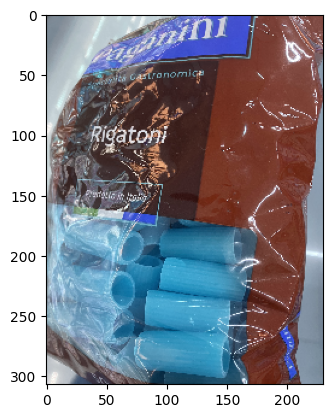

In [ ]:
path = "dataset/train/"

file_list = []

for root, dirs, files in os.walk(path):
  if len(files)>0:
    for file in files:
      file_list.append(f'{root}/{file}')

image = cv2.imread(file_list[0])
half = cv2.resize(image, (0, 0), fx = 0.15, fy = 0.15)

print(image.shape)
print(half.shape)

plt.imshow(half)
plt.show()

In [ ]:
os.mkdir(path_resized)


for image_path in file_list:
  category = image_path.split('/')[2]

  if not os.path.isdir(os.path.join(path_resized, category)):
    os.mkdir(os.path.join(path_resized, category))

  image = cv2.imread(image_path)
  half = cv2.resize(image, (0, 0), fx = 0.15, fy = 0.15)

  half_name = image_path.split('/')[-1]

  cv2.imwrite(os.path.join(f'{path_resized}/{category}/', half_name), half)



In [ ]:
train_path = path_resized
image_size = (307, 230)
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.0,
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 116 files belonging to 32 classes.


In [ ]:

labels = {class_name: i for i, class_name in enumerate(train_ds.class_names)}
labels

{'abacaxi': 0,
 'abobrinha': 1,
 'alface': 2,
 'alho': 3,
 'arroz': 4,
 'aveia': 5,
 'bacon': 6,
 'banana': 7,
 'batata': 8,
 'biscoito_oreo': 9,
 'brocolis': 10,
 'chocolate': 11,
 'couve_flor': 12,
 'filet_mignon': 13,
 'ketchup': 14,
 'laranja': 15,
 'leite': 16,
 'limao': 17,
 'linguica': 18,
 'maca': 19,
 'macarrao': 20,
 'manteiga': 21,
 'mortadela': 22,
 'mostarda': 23,
 'ovo': 24,
 'pao': 25,
 'pera': 26,
 'queijo_mussarela': 27,
 'salmao': 28,
 'sobrecoxa_frango': 29,
 'sucrilhos': 30,
 'tomate': 31}

In [ ]:
no_classes = len(labels)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
# Create the model
data_augmentation = keras.Sequential(
  [
  RandomFlip("horizontal",
                      input_shape=(307,230,
                                  3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)


kernel = 3
downscale = 2
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255, input_shape=(307, 230, 3))),
model.add(Conv2D(
        32, kernel,padding = 'same',
        activation = 'relu'))
model.add(MaxPooling2D(
        pool_size = (downscale, downscale)))
model.add(Conv2D(
        64, kernel,padding = 'same',  activation = 'relu'))
model.add(MaxPooling2D(
        pool_size = (downscale, downscale)))
model.add(Conv2D(
        64, kernel,padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(
        pool_size = (downscale, downscale)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

# Display a model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 307, 230, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 307, 230, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 307, 230, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 153, 115, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 153, 115, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 76, 57, 64)        0         
 g2D)                                                 

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(),
              metrics=['accuracy']
             )

# Start training
history = model.fit(
        train_ds,
        epochs =10,
        shuffle = False
)

Epoch 1/10
8/8 [==============================] - 2s 45ms/step - loss: 1.4246 - accuracy: 0.6121
Epoch 2/10
8/8 [==============================] - 0s 34ms/step - loss: 1.2326 - accuracy: 0.6810
Epoch 3/10
8/8 [==============================] - 0s 34ms/step - loss: 1.1641 - accuracy: 0.6466
Epoch 4/10
8/8 [==============================] - 0s 34ms/step - loss: 0.9162 - accuracy: 0.7586
Epoch 5/10
8/8 [==============================] - 0s 34ms/step - loss: 0.5444 - accuracy: 0.8793
Epoch 6/10
8/8 [==============================] - 0s 34ms/step - loss: 0.4333 - accuracy: 0.8621
Epoch 7/10
8/8 [==============================] - 0s 34ms/step - loss: 0.4514 - accuracy: 0.8879
Epoch 8/10
8/8 [==============================] - 0s 34ms/step - loss: 0.2318 - accuracy: 0.9397
Epoch 9/10
8/8 [==============================] - 0s 34ms/step - loss: 0.1689 - accuracy: 0.9828
Epoch 10/10
8/8 [==============================] - 0s 35ms/step - loss: 0.1416 - accuracy: 0.9483


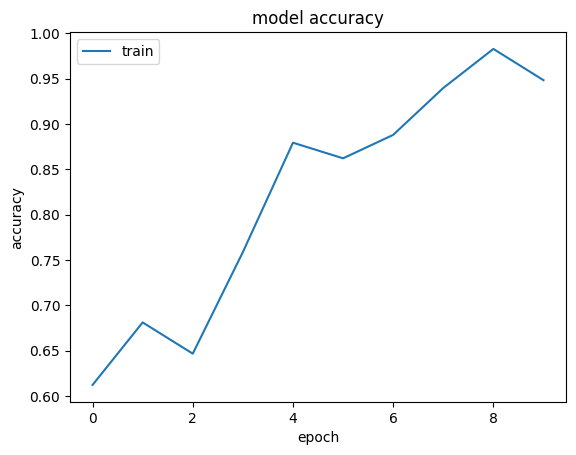

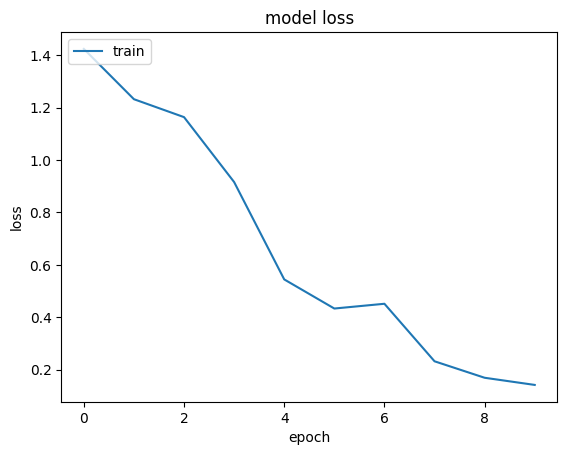

In [ ]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
import shutil

# Path to the directory you want to zip
directory_to_zip = 'saved_model/my_model'

# Path where you want to save the zip file
zip_file_path = 'drive/MyDrive/model.zip'

# Create a zip file from the directory
shutil.make_archive(zip_file_path[:-4], 'zip', directory_to_zip)

# Check if the zip file is created successfully
import os
if os.path.exists(zip_file_path):
    print("Zip file created successfully.")
else:
    print("Failed to create zip file.")

Zip file created successfully.
